In [14]:
import random
import matplotlib.pyplot as plt

S = 0
I = 1
R = 2

# THESE LATER
V = 3 # Vaccinated
Q = 4 # Quarantined


# TODOS: SCHEDULE
# Location indexed by time probably an array
# Indexed by time: Location ID: Int | None

# When simulating you check location and time match

# Locations should be randomly generated and have ID's

# Major based sheduling?

# Should we model parties?

class Location:
    def __init__(self, infection_rate):
        self.infection_rate = infection_rate
        self.bucket = []
        
class Person:
    def __init__(self, state=S):
        self.state = state
        self.recovery_prob = 0.1
        # self.schedule = schedule

# def pairs(lst):
#     for i, item1 in enumerate(lst):
#         for item2 in lst[i+1:]:
#             yield item1, item2
            
def people_with_state(people, state, time):
    return filter(lambda person: person.state == state and person.schedule[time] is not None, people)

def infection_pairs(people, time):
    for infected in people_with_state(people, I, time):
        for susceptible in people_with_state(people, S, time):
            if infected.schedule[time] == susceptible.schedule[time]:
                yield infected, susceptible
                
def find_new_infections(people, locations, time):
    new_infections = []
    for person1, person2 in infection_pairs(people, time):
        location = locations[person1.schedule[time]]
        if random.random() < location.infection_rate and person2 not in new_infections:
            new_infections.append(person2)
    return new_infections

def count_state(people, state):
    return sum(person.state == state for person in people)

def gen_locations(num_locations, num_people):
    locs = []

    for i in range(num_locations):
        infection_probability = random.uniform(1e-2, 5e-2)
        loc = Location(infection_probability)
        locs.append(loc)
        
    for j in range(24):
        r = set(range(0, num_people))
        for i in range(num_locations):
            if j < 8 or j > 19:
                locs[i].bucket.append([])
            else:
                samp = set(random.sample(r, k = num_people // num_locations))
                locs[i].bucket.append(list(samp))
                r = r - samp
    return locs


def gen_schedule(num_loocsnum_people):
    schedule = [None for i in range(24)]

    num_classes = random.randrange(2, 11)
    locs = random.sample(range(num_locs), k=num_classes)
    times = random.sample(range(8,18), k=num_classes)

    for time, loc in zip(times, locs):
        schedule[time] = loc

    # Potential high risk activity (parties and gatherings and homework?) out[18:]
    return schedule

def gen_people(num_people):
    ppl = []
    for i in range(num_people):
        status = random.choices([I, S], weights=[1,7])[0]
        # schedule = gen_schedule(num_locs)
        person = Person(status)
        ppl.append(person)

    return ppl

def simulate(people, locations, num_days):
    infected = [count_state(people, I)]
    recovered = [count_state(people, R)]
    susceptible = [count_state(people, S)]
    for day in range(num_days):
        # Infection
        for time in range(len(people[0].schedule)):
            for person in find_new_infections(people, locations, time):
                person.state = I
        # Recovery
        for person in people:
            if person.state == I and random.random() < person.recovery_prob:
                person.state = R
        # Count people
        infected.append(count_state(people, I))
        recovered.append(count_state(people, R))
        susceptible.append(count_state(people, S))

    return infected, recovered, susceptible


In [16]:
# In our initial model people got infected really fast but recovered really fast

NUM_LOCS = 100
NUM_PEOPLE = 2000
NUM_DAYS = 40

locations = gen_locations(NUM_LOCS, NUM_PEOPLE)

ppl = gen_people(num_people=NUM_PEOPLE)
# ppl = []
# for i in range(NUM_PEOPLE):
#     status = random.choices([I, S], weights=[1,7])[0]
#     schedule = gen_schedule(NUM_LOCS)
#     person = Person(schedule, status)
#     ppl.append(person)
    
i, r, s = simulate(ppl, locations, NUM_DAYS)

fig, ax = plt.subplots()
ax.plot(i)
ax.plot(r)
ax.plot(s)

ax.legend(["Infected", "Recovered", "Susceptible"])
ax.set_ylabel("People")
ax.set_xlabel("Days")

/var/folders/rc/f2_f50m13ms5cxv3s_3_x8zm0000gn/T/ipykernel_43083/1859233126.py:75: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  samp = set(random.sample(r, k = num_people // num_locations))


AttributeError: 'Person' object has no attribute 'schedule'

Text(0.5, 0, 'Days')

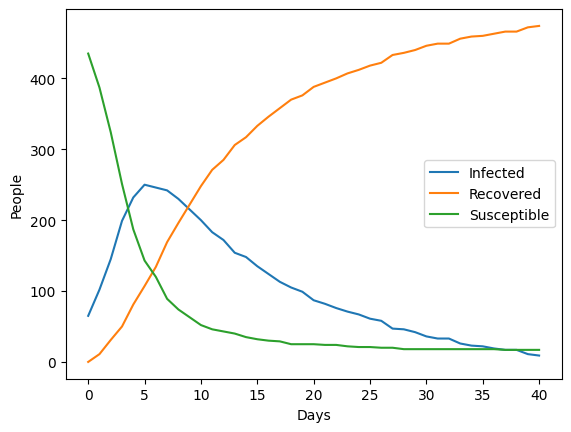

In [9]:
# In our initial model people got infected really fast but recovered really fast

NUM_LOCS = 50
NUM_PEOPLE = 500
NUM_DAYS = 40

locations = gen_locations(NUM_LOCS, NUM, PEOPLE)

ppl = []
for i in range(NUM_PEOPLE):
    status = random.choices([I, S], weights=[1,7])[0]
    schedule = gen_schedule(NUM_LOCS)
    person = Person(schedule, status)
    ppl.append(person)
    
i, r, s = simulate(ppl, locations, NUM_DAYS)

fig, ax = plt.subplots()
ax.plot(i)
ax.plot(r)
ax.plot(s)

ax.legend(["Infected", "Recovered", "Susceptible"])
ax.set_ylabel("People")
ax.set_xlabel("Days")

In [13]:
gen_locations(1000, 20000)

/var/folders/rc/f2_f50m13ms5cxv3s_3_x8zm0000gn/T/ipykernel_43083/219260986.py:75: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  samp = set(random.sample(r, k = num_people // num_locations))
